# Data and Statistics Packages

### Florian Oswald

**This is lecture is a slightly modified version of https://lectures.quantecon.org/jl/data_statistical_packages.html**
**Thank you to the amazing Quantecon.org team!**

## Contents

- [Data and Statistics Packages](#Data-and-Statistics-Packages)  
  - [Overview](#Overview)  
  - [DataFrames](#DataFrames)  
  - [Statistics and Econometrics](#Statistics-and-Econometrics)  

## Overview

This lecture explores some of the key packages for working with data and doing statistics in Julia

In particular, we will examine the `DataFrame` object in detail (i.e., construction, manipulation, querying, visualization, and nuances like missing data)

While Julia is not an ideal language for pure cookie-cutter statistical analysis, it has many useful packages to provide those tools as part of a more general solution

Examples include `GLM.jl` and `FixedEffectModels.jl`, which we discuss

This list is not exhaustive, and others can be found in organizations such as [JuliaStats](https://github.com/JuliaStats), [JuliaData](https://github.com/JuliaData/), and  [QueryVerse](https://github.com/queryverse)

In [1]:
using LinearAlgebra, Statistics


In [2]:
using DataFrames, RDatasets, DataFramesMeta, CategoricalArrays, Query, VegaLite


In [3]:
using DataVoyager, GLM, RegressionTables, FixedEffectModels

## DataFrames

A useful package for working with data is [DataFrames.jl](https://github.com/JuliaStats/DataFrames.jl)

The most important data type provided is a `DataFrame`, a two dimensional array for storing heterogeneous data

Although data can be heterogeneous within a `DataFrame`, the contents of the columns must be homogeneous
(of the same type)

This is analogous to a `data.frame` in R, a `DataFrame` in Pandas (Python) or, more loosely, a spreadsheet in Excel

There are a few different ways to create a DataFrame

### Constructing a DataFrame

The first is to set up columns and construct a dataframe by assigning names

In [4]:
using DataFrames, RDatasets  # RDatasets provides good standard data examples from R

# note use of missing
commodities = ["crude", "gas", "gold", "silver"]
last_price = [4.2, 11.3, 12.1, missing]
df = DataFrame(commod = commodities, price = last_price)

,commod,price
,String,Float64?
1,crude,4.2
2,gas,11.3
3,gold,12.1
4,silver,missing


Columns of the `DataFrame` can be accessed by name using a symbol `df[:row]` or a struct-style `df.row`, as below

In [5]:
df[!,:price]

4-element Vector{Union{Missing, Float64}}:
  4.2
 11.3
 12.1
   missing

In [6]:
df.price

4-element Vector{Union{Missing, Float64}}:
  4.2
 11.3
 12.1
   missing

Note that the type of this array has values `Union{Missing, Float64}` since it was created with a `missing` value

In [7]:
df.commod

4-element Vector{String}:
 "crude"
 "gas"
 "gold"
 "silver"

The `DataFrames.jl` package provides a number of methods for acting on `DataFrame`’s, such as `describe`

In [8]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,commod,,crude,,silver,0,String
2,price,9.2,4.2,11.3,12.1,1,"Union{Missing, Float64}"


While often data will be generated all at once, or read from a file, you can **add to** a `DataFrame` by providing the key parameters

In [9]:
nt = (commod = "nickel", price= 5.1)
push!(df, nt)

,commod,price
,String,Float64?
1,crude,4.2
2,gas,11.3
3,gold,12.1
4,silver,missing
5,nickel,5.1


Named tuples can also be used to construct a `DataFrame`, and have it properly deduce all types

In [10]:
ntx = (t = 1, col1 = 3.0)
df2 = DataFrame([ntx])
push!(df2, (t=2, col1 = 4.0))

,t,col1
,Int64,Float64
1,1,3.0
2,2,4.0


### Working with Missing

As we discussed in [fundamental types](https://lectures.quantecon.org/jl/fundamental_types.html#missing), the semantics of `missing` are that mathematical operations will not silently ignore it

In order to allow `missing` in a column, you can create/load the `DataFrame`
from a source with `missing`’s, or call `allowmissing!` on a column

In [11]:
allowmissing!(df2, :col1) # necessary to add in a for col1
push!(df2, (t=3, col1 = missing))
push!(df2, (t=4, col1 = 5.1))

,t,col1
,Int64,Float64?
1,1,3.0
2,2,4.0
3,3,missing
4,4,5.1


In [12]:
eltype(df2.col1)

Union{Missing, Float64}

We can see the propagation of `missing` to caller functions, as well as a way to efficiently calculate with non-missing data

In [13]:
@show mean(df2.col1)
@show mean(skipmissing(df2.col1))

mean(df2.col1) = missing
mean(skipmissing(df2.col1)) = 4.033333333333333


4.033333333333333

And to replace the `missing`

In [14]:
df2.col1  .= coalesce.(df2.col1, 0.0) # replace all missing with 0.0

4-element Vector{Union{Missing, Float64}}:
 3.0
 4.0
 0.0
 5.1

### Manipulating and Transforming DataFrames

One way to do an additional calculation with a `DataFrame` is to tuse the `@transform` macro from `DataFramesMeta.jl`

In [15]:
using DataFramesMeta
f(x) = x^2
df2 = @transform(df2, col2 = f.(:col1), col3 = ones(size(df2,1)))

,t,col1,col2,col3
,Int64,Float64?,Float64,Float64
1,1,3.0,9.0,1.0
2,2,4.0,16.0,1.0
3,3,0.0,0.0,1.0
4,4,5.1,26.01,1.0




### Categorical Data

For data that is [categorical](https://juliadata.github.io/DataFrames.jl/stable/man/categorical.html#Categorical-Data-1)

In [16]:
using CategoricalArrays
id = [1, 2, 3, 4]
y = ["old", "young", "young", "old"]
y = CategoricalArray(y)
df = DataFrame(id=id, y=y)

,id,y
,Int64,Cat…
1,1,old
2,2,young
3,3,young
4,4,old


In [17]:
levels(df.y)

2-element Vector{String}:
 "old"
 "young"

### Visualization, Querying, and Plots

The `DataFrame` (and similar types that fulfill a standard generic interface) can fit into a variety of packages

One set of them is the [QueryVerse](https://github.com/queryverse)

**Note:** The QueryVerse, in the same spirit as R’s tidyverse, makes heavy use of the pipeline syntax `|>`

In [18]:
x = 3.0
f(x) = x^2
g(x) = log(x)

@show g(f(x))
@show x |> f |> g; # pipes nest function calls

g(f(x)) = 2.1972245773362196
(x |> f) |> g = 2.1972245773362196


To give an example directly from the source of the LINQ inspired [Query.jl](http://www.queryverse.org/Query.jl/stable/)

In [19]:
using Query

df = DataFrame(name=["John", "Sally", "Kirk"], age=[23., 42., 59.], children=[3,5,2])

x = @from i in df begin
    @where i.age>50
    @select {i.name, i.children}
    @collect DataFrame
end

,name,children
,String,Int64
1,Kirk,2


While it is possible to just use the `Plots.jl` library, there may be better options for displaying tabular data – such as [VegaLite.jl](http://fredo-dedup.github.io/VegaLite.jl/latest/)

In [20]:
# Error with VegaLite and NodeJS in Jupyter
#using RDatasets, VegaLite
#iris = dataset("datasets", "iris")

#iris |> @vlplot(
#    :point,
#    x=:PetalLength,
#    y=:PetalWidth,
#    color=:Species
#)

Another useful tool for exploring tabular data is [DataVoyager.jl](https://github.com/queryverse/DataVoyager.jl)

```julia
using DataVoyager
iris |> Voyager()
```


## Statistics and Econometrics

While Julia is not intended as a replacement for R, Stata, and similar specialty languages, it has a growing number of packages aimed at statistics and econometrics

Many of the packages live in the [JuliaStats organization](https://github.com/JuliaStats/)

A few to point out

- [StatsBase](https://github.com/JuliaStats/StatsBase.jl) has basic statistical functions such as geometric and harmonic means, auto-correlations, robust statistics, etc.  
- [StatsFuns](https://github.com/JuliaStats/StatsFuns.jl) has a variety of mathematical functions and constants such as pdf and cdf of many distributions, softmax, etc.  

### General Linear Models

To run linear regressions and similar statistics, use the [GLM](http://juliastats.github.io/GLM.jl/latest/) package

In [21]:
using GLM

x = randn(100)
y = 0.9 .* x + 0.5 * rand(100)
df = DataFrame(x=x, y=y)
ols = lm(@formula(y ~ x), df) # R-style notation

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.232384   0.0143618  16.18    <1e-28   0.203883   0.260884
x            0.879822   0.0142717  61.65    <1e-79   0.851501   0.908144
────────────────────────────────────────────────────────────────────────

To display the results in a useful tables for LaTeX and the REPL, use
[RegressionTables](https://github.com/jmboehm/RegressionTables.jl/) developed at SciencesPo by [Johannes Böhm](https://jmboehm.github.io) for output
similar to the Stata package esttab and the R package stargazer

In [22]:
# Need to install NVIDIA Cuda (?)
using RegressionTables
regtable(ols)


----------------------
                  y   
              --------
                   (1)
----------------------
(Intercept)   0.232***
               (0.014)
x             0.880***
               (0.014)
----------------------
Estimator          OLS
----------------------
N                  100
R2               0.975
----------------------




### Fixed Effects

While Julia may be overkill for estimating a simple linear regression,
fixed-effects estimation with dummies for multiple variables are much more computationally intensive. The [FixedEffectsModel.jl](https://github.com/matthieugomez/FixedEffectModels.jl) is a great tool for this task.

For a 2-way fixed-effect, taking the example directly from the documentation using [cigarette consumption data](https://github.com/johnmyleswhite/RDatasets.jl/blob/master/doc/plm/rst/Cigar.rst)

In [23]:
using FixedEffectModels
cigar = dataset("plm", "Cigar")
cigar.StateCategorical =  categorical(cigar.State)   # convert to categorical data type
cigar.YearCategorical =  categorical(cigar.Year)

describe(cigar)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,State,26.8261,1,26.5,51,0,Int64
2,Year,77.5,63,77.5,92,0,Int64
3,Price,68.6999,23.4,52.3,201.9,0,Float64
4,Pop,4537.11,319.0,3174.0,30703.3,0,Float64
5,Pop16,3366.62,215.2,2315.3,22920.0,0,Float64
6,CPI,73.5967,30.6,62.9,140.3,0,Float64
7,NDI,7525.02,1322.57,6281.2,23074.0,0,Float64
8,Sales,123.951,53.4,121.2,297.9,0,Float64
9,Pimin,62.8993,23.4,46.4,178.5,0,Float64


In [24]:
fixedeffectresults = reg(cigar, 
  @formula(Sales ~ NDI + fe(StateCategorical) + fe(YearCategorical)), 
   Vcov.cluster(:StateCategorical), 
   weights = :Pop)

regtable(fixedeffectresults)

Demean Variables: [================================>]  2/2
----------------------------
                     Sales  
                   ---------
                         (1)
----------------------------
NDI                -0.005***
                     (0.001)
----------------------------
StateCategorical         Yes
YearCategorical          Yes
----------------------------
Estimator                OLS
----------------------------
N                      1,380
R2                     0.803
----------------------------




## R LFE vs FixedEffects.jl Shootout

* High dimensional Fixed effect estimation is compuationally intensive
* The R packge [lfe](https://cran.r-project.org/web/packages/lfe/index.html) is a good option that uses multithreading, if available.
* Let's see how FixedEffects.jl compares to it.

In [25]:
"""
    FEbenchmark(;N=10_000_000,K= 100)

A function to create a 2-way fixed effect dataset. `N` observations, `K` 
and `N/K` categories for Fixed effects respectively. We generate 7 regressors as well as a weight vector.
"""
function FEbenchmark(;N=10_000_000,K= 100)
    id1_int = Int.(rand(1:(N/K), N))
    id2_int = Int.(rand(1:K, N))
    w = cos.(id1_int)
    
    x1 = 5 * cos.(id1_int) + 5 * sin.(id2_int) + randn(N)
    x2 =  cos.(id1_int) + sin.(id2_int) + randn(N)
    x3 =  cos.(id1_int) + sin.(id2_int) + randn(N)
    x4 =  cos.(id1_int) + sin.(id2_int) + randn(N)
    x5 =  cos.(id1_int) + sin.(id2_int) + randn(N)
    x6 =  cos.(id1_int) + sin.(id2_int) + randn(N)
    x7 =  cos.(id1_int) + sin.(id2_int) + randn(N)
    y= 3 .* x1 .+ 5 .* x2 .+ x3 .+ x4 .+ x5 .+ x6 .+ x7 .+ cos.(id1_int) .+ cos.(id2_int).^2 .+ randn(N)
    df = DataFrame(id1 = categorical(id1_int),id1_int = id1_int, 
                   id2 = categorical(id2_int), id2_int = id2_int,
                   x1 = x1, 
                   x2 = x2,
                   x3 = x3,
                   x4 = x4,
                   x5 = x5,
                   x6 = x6,
                   x7 = x7,        
                   w = w, y = y)
    df
end


FEbenchmark

In [26]:
# create our dataset
df = FEbenchmark()

# run a bunch of different models
# the comments show timings of a previous version of FixedEffectModels (faster!)
@time reg(df, @formula(y ~ x1 + x2))
# 0.582029 seconds (852 allocations: 535.311 MiB, 18.28% gc time)
@time reg(df, @formula(y ~ x1 + x2), Vcov.cluster(:id2))
# 0.809652 seconds (1.55 k allocations: 649.821 MiB, 14.40% gc time)
@time reg(df, @formula(y ~ x1 + x2 + fe(id1)))
# 1.655732 seconds (1.21 k allocations: 734.353 MiB, 16.88% gc time)
@time reg(df, @formula(y ~ x1 + x2 + fe(id1)), Vcov.cluster(:id1))
#  2.113248 seconds (499.66 k allocations: 811.751 MiB, 15.08% gc time)
@time reg(df, @formula(y ~ x1 + x2 + fe(id1) + fe(id2)))
# 3.553678 seconds (1.36 k allocations: 1005.101 MiB, 10.55% gc time))

# let's take the biggest model as our benchmark timing
@time result = reg(df, @formula(y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + fe(id1) + fe(id2)))

  2.943994 seconds (2.78 M allocations: 857.296 MiB, 12.78% gc time, 67.08% compilation time)
  1.503248 seconds (646.29 k allocations: 768.406 MiB, 18.51% compilation time)
  5.452844 seconds (1.41 M allocations: 978.314 MiB, 6.49% gc time, 23.01% compilation time)
  6.172604 seconds (270.14 k allocations: 952.330 MiB, 1.30% gc time, 3.33% compilation time)
  8.535271 seconds (342.05 k allocations: 1.003 GiB, 1.15% gc time, 2.90% compilation time)
 20.693277 seconds (2.11 M allocations: 3.343 GiB, 1.73% gc time, 7.50% compilation time)


                      Fixed Effect Model                      
Number of obs:        10000000  Degrees of freedom:     100107
R2:                      0.999  R2 Adjusted:             0.999
F Statistic:         5.51529e7  p-value:                 0.000
R2 within:               0.975  Iterations:                  6
Converged:                true  
     Estimate   Std.Error t value Pr(>|t|) Lower 95% Upper 95%
--------------------------------------------------------------
x1    2.99976 0.000317919 9435.59    0.000   2.99914   3.00038
x2    5.00043 0.000317892 15730.0    0.000    4.9998   5.00105
x3    1.00073 0.000317995 3147.01    0.000   1.00011   1.00136
x4   0.999984 0.000317964 3144.96    0.000  0.999361   1.00061
x5    1.00025 0.000317886 3146.58    0.000   0.99963   1.00088
x6    1.00048 0.000318047 3145.68    0.000  0.999854    1.0011
x7   0.999891 0.000317865 3145.64    0.000  0.999268   1.00051


In [27]:
# using R lfe package
using RCall
rstring = R"""
# factorize data
# notice that we have to pass the integer data in id1_int.
r_d = $df
r_d[,"id1"] = factor(r_d[,"id1_int"])
r_d[,"id2"] = factor(r_d[,"id2_int"])

library(lfe)
lfe_time = system.time(lfe <- felm(y ~x1 + x2 + x3 + x4 + x5 + x6 + x7| id1 + id2, data=r_d))
print(paste0("R lfe time: ",lfe_time[1]))
print(summary(lfe))

# also fixest
fixest_time = system.time(fe <- fixest::feols(y ~x1 + x2 + x3 + x4 + x5 + x6 + x7 | id1 + id2, data=r_d))
print(paste0("R fixest time: ",fixest_time[1]))



list(lfe = lfe_time[1], fixest = fixest_time[1])
#
## OLS.
#ols <- lm(y ~x1 + x2 + x3 + x4 + x5 + x6 + x7 + id1 + id2 -1, data=r_d)
#summary(ols)
"""


┌ Warning: RCall.jl: Loading required package: Matrix
└ @ RCall /Users/74097/.julia/packages/RCall/eRsxl/src/io.jl:160


[1] "R lfe time: 37.465"

Call:
   felm(formula = y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 | id1 + id2,      data = r_d) 

Residuals:
    Min      1Q  Median      3Q     Max 
-5.2519 -0.6715 -0.0002  0.6715  5.2019 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
x1 2.9997583  0.0003179    9436   <2e-16 ***
x2 5.0004266  0.0003179   15730   <2e-16 ***
x3 1.0007340  0.0003180    3147   <2e-16 ***
x4 0.9999839  0.0003180    3145   <2e-16 ***
x5 1.0002528  0.0003179    3147   <2e-16 ***
x6 1.0004769  0.0003180    3146   <2e-16 ***
x7 0.9998912  0.0003179    3146   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1 on 9899894 degrees of freedom
Multiple R-squared(full model): 0.9986   Adjusted R-squared: 0.9986 
Multiple R-squared(proj model): 0.975   Adjusted R-squared: 0.9747 
F-statistic(full model):6.899e+04 on 100105 and 9899894 DF, p-value: < 2.2e-16 
F-statistic(proj model): 5.515e+07 on 7 and 9899894 DF, p-value: < 2.2e

RObject{VecSxp}
$lfe
user.self 
   37.465 

$fixest
user.self 
    11.58 



Ok, so R{Fixest} is pretty fast. there is another ace up our sleeve though. the GPU. If you have a CUDA-enabled GPU installed (details at https://github.com/JuliaGPU/CUDA.jl), then you can this:

In [28]:
using CUDA
@time result = reg(df, 
    @formula(y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + fe(id1) + fe(id2)),
    method = :GPU,
    double_precision = false)

LoadError: MethodError: no method matching FixedEffects.AbstractFixedEffectSolver{Float32}(::Vector{FixedEffects.FixedEffect}, ::StatsBase.UnitWeights{Int64}, ::Type{Val{:GPU}}, ::Int64)
[0mClosest candidates are:
[0m  FixedEffects.AbstractFixedEffectSolver{T}(::Vector{var"#s44"} where var"#s44"<:FixedEffects.FixedEffect, ::StatsBase.AbstractWeights, [91m::Type{Val{:cpu}}[39m, ::Any) where T at /Users/74097/.julia/packages/FixedEffects/KU4dM/src/FixedEffectSolvers/FixedEffectSolverCPU.jl:111
[0m  FixedEffects.AbstractFixedEffectSolver{T}(::Vector{var"#s45"} where var"#s45"<:FixedEffects.FixedEffect, ::StatsBase.AbstractWeights, [91m::Type{Val{:cpu}}[39m) where T at /Users/74097/.julia/packages/FixedEffects/KU4dM/src/FixedEffectSolvers/FixedEffectSolverCPU.jl:111
[0m  FixedEffects.AbstractFixedEffectSolver{T}(::Vector{var"#s46"} where var"#s46"<:FixedEffects.FixedEffect, ::StatsBase.AbstractWeights, [91m::Type{Val{:lsmr_gpu}}[39m) where T at /Users/74097/.julia/packages/FixedEffects/KU4dM/src/AbstractFixedEffectSolver.jl:99
[0m  ...

In [29]:
# use option save=true to store estimated fixed effects
@time result = reg(df, @formula(y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + fe(id1) + fe(id2)), save = true)

regtable(result)


Demean Variables: [================================>]  8/8 41.184708 seconds (33.07 M allocations: 5.644 GiB, 5.19% gc time, 4.57% compilation time)

----------------------
                 y    
            ----------
                   (1)
----------------------
x1            3.000***
               (0.000)
x2            5.000***
               (0.000)
x3            1.001***
               (0.000)
x4            1.000***
               (0.000)
x5            1.000***
               (0.000)
x6            1.000***
               (0.000)
x7            1.000***
               (0.000)
----------------------
id1                Yes
id2                Yes
----------------------
Estimator          OLS
----------------------
N           10,000,000
R2               0.999
----------------------




In [30]:
cor(result.fe.fe_id1,result.fe.fe_id2)   # AKM sorting?

6.26278207149361e-5

In [31]:
# more models
result2 = reg(df, @formula(y ~ x1 + x2 + x3 + fe(id1) + fe(id2)))
result3 = reg(df, @formula(y ~ x1      + x3 + fe(id1)  ))

Demean Variables: [================================>]  4/4

                      Fixed Effect Model                      
Number of obs:        10000000  Degrees of freedom:     100002
R2:                      0.953  R2 Adjusted:             0.952
F Statistic:         4.81124e7  p-value:                 0.000
R2 within:               0.907  Iterations:                  1
Converged:                true  
     Estimate   Std.Error t value Pr(>|t|) Lower 95% Upper 95%
--------------------------------------------------------------
x1    4.60748 0.000597346 7713.26    0.000   4.60631   4.60865
x3    1.32043  0.00179441 735.857    0.000   1.31691   1.32395


In [32]:
# how to look at those? -> regtable!
regtable(result, result2, result3 )


------------------------------------------------
                              y                 
            ------------------------------------
                   (1)          (2)          (3)
------------------------------------------------
x1            3.000***     3.001***     4.607***
               (0.000)      (0.001)      (0.001)
x2            5.000***     5.001***             
               (0.000)      (0.001)             
x3            1.001***     1.000***     1.320***
               (0.000)      (0.001)      (0.002)
x4            1.000***                          
               (0.000)                          
x5            1.000***                          
               (0.000)                          
x6            1.000***                          
               (0.000)                          
x7            1.000***                          
               (0.000)                          
------------------------------------------------
id1                

In [33]:
# latex?
regtable(result, result2, result3, renderSettings = latexOutput() )  # latexOutput(filename::String)

\begin{tabular}{lrrr}
\toprule
          &         \multicolumn{3}{c}{y}        \\ 
\cmidrule(lr){2-4} 
          &        (1) &        (2) &        (3) \\ 
\midrule
x1        &   3.000*** &   3.001*** &   4.607*** \\ 
          &    (0.000) &    (0.001) &    (0.001) \\ 
x2        &   5.000*** &   5.001*** &            \\ 
          &    (0.000) &    (0.001) &            \\ 
x3        &   1.001*** &   1.000*** &   1.320*** \\ 
          &    (0.000) &    (0.001) &    (0.002) \\ 
x4        &   1.000*** &            &            \\ 
          &    (0.000) &            &            \\ 
x5        &   1.000*** &            &            \\ 
          &    (0.000) &            &            \\ 
x6        &   1.000*** &            &            \\ 
          &    (0.000) &            &            \\ 
x7        &   1.000*** &            &            \\ 
          &    (0.000) &            &            \\ 
\midrule
id1       &        Yes &        Yes &        Yes \\ 
id2       &        Yes &      

In [34]:
# options
regtable(result, result2, result3 , below_statistic = :blank)


------------------------------------------------
                              y                 
            ------------------------------------
                   (1)          (2)          (3)
------------------------------------------------
x1            3.000***     3.001***     4.607***
                                                
x2            5.000***     5.001***             
                                                
x3            1.001***     1.000***     1.320***
                                                
x4            1.000***                          
                                                
x5            1.000***                          
                                                
x6            1.000***                          
                                                
x7            1.000***                          
                                                
------------------------------------------------
id1                

In [35]:
using GLM
ols = lm(@formula(y ~ x1 + x2),df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x1 + x2

Coefficients:
────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  0.497495  0.000865756    574.64    <1e-99   0.495798   0.499192
x1           4.01816   0.000235477  17063.95    <1e-99   4.0177     4.01862
x2           5.2044    0.000849346   6127.54    <1e-99   5.20273    5.20606
────────────────────────────────────────────────────────────────────────────

In [36]:
regtable(result, result2,ols,below_decoration = s -> "[$(s)]")


--------------------------------------------------
                                y                 
              ------------------------------------
                     (1)          (2)          (3)
--------------------------------------------------
x1              3.000***     3.001***     4.018***
                 [0.000]      [0.001]      [0.000]
x2              5.000***     5.001***     5.204***
                 [0.000]      [0.001]      [0.001]
x3              1.001***     1.000***             
                 [0.000]      [0.001]             
x4              1.000***                          
                 [0.000]                          
x5              1.000***                          
                 [0.000]                          
x6              1.000***                          
                 [0.000]                          
x7              1.000***                          
                 [0.000]                          
(Intercept)                   

💪 [@jmboehm](https://twitter.com/johannesmboehm)

To explore the data use the interactive DataVoyager and VegaLite

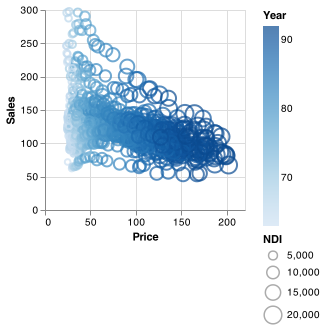

In [37]:
# cigar |> Voyager()

cigar |> @vlplot(
    :point,
    x=:Price,
    y=:Sales,
    color=:Year,
    size=:NDI
)